<a href="https://colab.research.google.com/github/Smontillo/One_to_Many_LSTM_Harmonic_Motion/blob/main/LSTM_pythorch_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch code to for a One-to-Many NN-LSTM

In a One-to-Many LSTM, one vector is used to predict the next steps in a time sequence.

Here, will predict the behavior of a Harmonic oscillator by just giving the initial x and p, the NN will evolve for any number of steps.

## Loading of Packages

In [282]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

## Parameters for the Harmonic Oscillator

$x(t) = A \cos(\omega \cdot t + \psi) \qquad p(t) = -m\omega A \sin(\omega \cdot t + \psi)$

For learning purposes, we will only look at one oscillator. The generalization is straight forward.

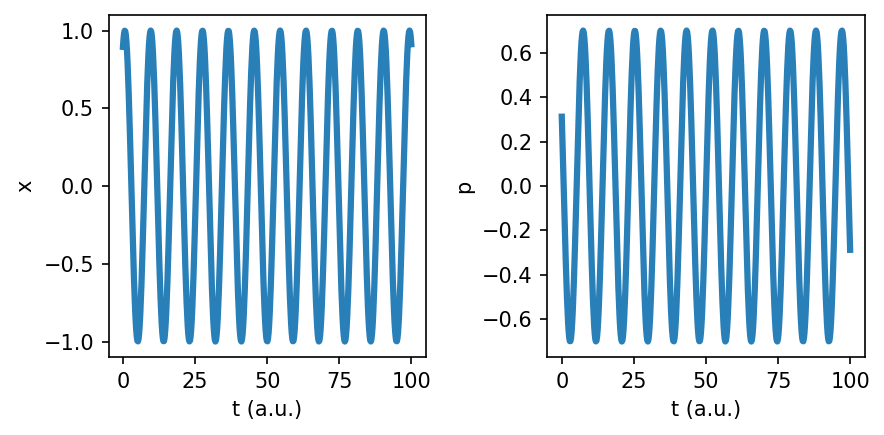

In [283]:
feat  = 2
ntraj = 1
t_len = 500
A, w, m = 1, 0.7, 1
t     = np.linspace(0, 100, t_len)
ψ     = np.random.uniform(-np.pi, np.pi, ntraj)
x     = np.zeros((ntraj, t_len))
p     = np.zeros((ntraj, t_len))

for ψi in range(ntraj):
  x[ψi,:] = A * np.cos(w * t + ψ[ψi])
  p[ψi,:] = - m * w * A * np.sin(w * t + ψ[ψi])

fig, ax = plt.subplots(1,2,figsize=(6, 3), dpi =150)
for k in range(1):
  ax[0].plot(t, x[k,:], lw = 3, c = '#2980b9')
  ax[1].plot(t, p[k,:], lw = 3, c = '#2980b9')
ax[0].set_xlabel('t (a.u.)')
ax[1].set_xlabel('t (a.u.)')
ax[0].set_ylabel('x')
ax[1].set_ylabel('p')
fig.tight_layout()
plt.show()

## Data Preparation

The data created has the following shape:
$$
{X}^{(k)} = [{X}^{(k)}_{t_0}, {X}^{(k)}_{t_1}, \cdots, {X}^{(k)}_{t_n} ]
$$
Where $X^{(k)}_{t_i}$ is a vector containing the position and momenta (which are the features of the model) associated with trajectory $k$ (in this example $k = 1$) at time $t_i$. \\
We need our LSTM to learn the patterns concerning the motion of the oscillator. For that, we will partition the data of ${X}^{(k)}$ into chunks of sub-sets $S^{(k)}_i$ that contain $L$ consequent time steps (it is important to mantain the time ordering within these arrays). A total of (t_len - $L$ + 1) arrays are created.
$$
X^{(k)}(T)\rightarrow [S^{(k)}_0(t_0 - t_L), S^{(k)}_1(t_1 - t_{L+1}), \cdots,S^{(k)}_N(t_{t} - t_{t+L})]
$$
Therefore, each $S^{(k)}_i$ has dimensions $(L,\text{features})$.

In [284]:
Data = np.zeros((t_len,2))       # x and p are combined in one array
Data[:,0], Data[:,1] = x, p
L    = 5                         # length of the subarrays S_i
size = t_len - L + 1             # number of subarrays S_i
Si   = np.zeros((size, L, 2))    # subarrays
for k in range(size):
  Si[k,:,:] = Data[k:k+L,:]
print('Size of S_i --->', size)

Size of S_i ---> 496


## Division into Training (X_training, Y_training) and Testing (X_testing, Y_testing)

The $S^{(k)}_i$ arrays are partitioned for training ($X_{train}, Y_{train}$) and testing ($X_{test}, Y_{test}$) in a ratio of $7:3$. \\
For this NN, we will use the first vector of each $S^{(k)}_i$ as the $X_{train}$ and the next $L-1$ vectors are used for $Y_{train}$. This is why is the approach is known as *One-to-Many*. The same approach is used for the $X_{test}$ and $Y_{test}$.
$$
X_{train} = S_i^{(k)}\left[0,:\right] \qquad Y_{train} = S_i^{(k)}\left[1:,:\right]
$$

In [285]:
ratio   = 0.7
s_train, s_test = int(size * ratio), size - int(size * ratio)                # Trainin and testing size
X_train, Y_train = np.zeros((s_train, L-1, 2)), np.zeros((s_train, L-1, 2))  # Training sets
X_test, Y_test   = np.zeros((s_test, L-1, 2)), np.zeros((s_test, L-1, 2))    # Testintg sets
print('Train Size --->', s_train, '|', 'Test Size --->', s_test)
# PARTITION OF S_i =======================
X_train[:,0,:], Y_train[:,:,:] = Si[:s_train,0,:], Si[:s_train,1:,:]
X_test[:,0,:], Y_test[:,:,:]   = Si[s_train:,0,:], Si[s_train:,1:,:]
# CONVERT TO PYTHORCH TENSOR =============
X_train = torch.tensor(X_train, dtype = torch.float32)
Y_train = torch.tensor(Y_train, dtype = torch.float32)
X_test  = torch.tensor(X_test, dtype = torch.float32)
Y_test  = torch.tensor(Y_test, dtype = torch.float32)

Train Size ---> 347 | Test Size ---> 149


## Creation of the NN-LSTM

In Pytorch, the LSTM module takes:
*   input_dim $\Longrightarrow$ Number of the features.
*   hidden_dim $\Longrightarrow$ Number of  "neurons" that compose the LSTM model.
*   layer_dim $\Longrightarrow$ Number of LSTM modules (LSTM modules can be stacked on each other for a single time step).
*  output_dim $\Longrightarrow$ number of features that must exit the LSTM \\
Further, each LSTM must have a DENSE layer (called fc in PyTorch) that condenses every output of the neurons that compose the LSTM cell to generate the output_dim data.

Further, a forward function is needed to pass the outputs (short-term state vector $h_{t-1}$ and long-term state vector $c_{t-1}$) of a time step $t -1$ to the next time $t$.


In [286]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
    super(LSTM, self).__init__()
    self.hidden_dim = hidden_dim
    self.layer_dim  = layer_dim
    self.lstm       = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first = True) # batch_first to have (batch_dim, seq_dim, feature_dim)
    self.fc         = nn.Linear(hidden_dim, output_dim) # This is the DENSE layer, which combines the information from the LSTM to produce an output.

  def forward(self, x):
    # Initialize hidden and cell states (h0 and c0)
      h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
      c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
      # Forward propagate LSTM
      out, _ = self.lstm(x, (h0, c0))
      # Predict next states for all time steps
      out = self.fc(out)
      return out

# Definition of Hyperparameters

In [305]:
input_dim, hidden_dim, layer_dim, output_dim  = feat, 200, 1, feat
num_epochs, batch_size, learning_rate         = 300, 30, 0.0001
model = LSTM(input_dim, hidden_dim, layer_dim, output_dim) # Initialization of the LSTM

# Training

In [317]:
# Create Dataloaders (This allows to pass the data from CPU to GPU)
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size = batch_size, shuffle = True)
val_loader   = DataLoader(TensorDataset(X_test, Y_test), batch_size = batch_size, shuffle = True)

In [318]:
# ------------------------
# Training Function
# ------------------------
def train_model(model, train_loader, val_loader, num_epochs, learning_rate, device):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_train, loss_test = [], []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for X_batch, Y_batch in train_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            Y_pred = model(X_batch)
            loss = criterion(Y_pred, Y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        # Validation Loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, Y_val in val_loader:
                X_val, Y_val = X_val.to(device), Y_val.to(device)
                Y_val_pred = model(X_val)
                val_loss += criterion(Y_val_pred, Y_val).item()
        loss_train.append(train_loss / len(train_loader))
        loss_test.append(val_loss / len(val_loader))
        if (epoch+1) % 20 == 0:
          print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {'{:e}'.format(train_loss/len(train_loader))}, Val Loss: {'{:e}'.format(val_loss/len(val_loader))}")
    return loss_train, loss_test

In [319]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Move the model to the GPU
loss_train, loss_test = train_model(model, train_loader, val_loader, num_epochs, learning_rate, device)

Epoch [20/300], Train Loss: 2.264530e-06, Val Loss: 2.791059e-06
Epoch [40/300], Train Loss: 1.869224e-06, Val Loss: 1.749317e-06
Epoch [60/300], Train Loss: 1.860092e-06, Val Loss: 1.629178e-06
Epoch [80/300], Train Loss: 1.648038e-06, Val Loss: 1.482217e-06
Epoch [100/300], Train Loss: 1.502028e-06, Val Loss: 1.327085e-06
Epoch [120/300], Train Loss: 1.108208e-06, Val Loss: 1.053707e-06
Epoch [140/300], Train Loss: 1.105370e-06, Val Loss: 1.081237e-06
Epoch [160/300], Train Loss: 1.019963e-06, Val Loss: 1.000628e-06
Epoch [180/300], Train Loss: 1.268749e-06, Val Loss: 1.370709e-06
Epoch [200/300], Train Loss: 8.927399e-07, Val Loss: 9.409531e-07
Epoch [220/300], Train Loss: 8.826496e-07, Val Loss: 9.109128e-07
Epoch [240/300], Train Loss: 8.341804e-07, Val Loss: 8.172131e-07
Epoch [260/300], Train Loss: 9.708199e-07, Val Loss: 9.818579e-07
Epoch [280/300], Train Loss: 7.634419e-07, Val Loss: 7.688879e-07
Epoch [300/300], Train Loss: 7.896273e-07, Val Loss: 8.755422e-07


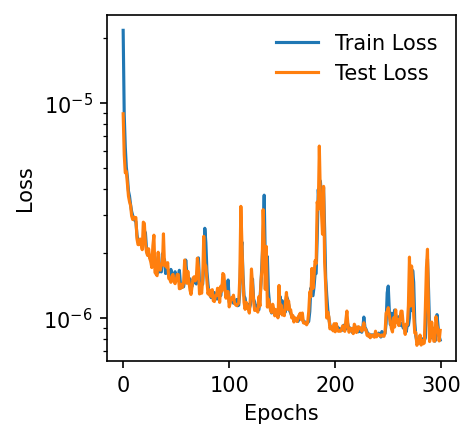

In [320]:
fig, ax = plt.subplots(figsize=(3,3), dpi = 150)
ax.plot(range(len(loss_train)), loss_train, label = 'Train Loss')
ax.plot(range(len(loss_test)), loss_test, label = 'Test Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend(frameon = False)
ax.set_yscale('log')
plt.show()

## Predicting using the Model

In [321]:
def predict_traj(model, initial_state, num_steps, device):
  model.eval()
  s                = L - 1                                                    # Number of time steps to predict
  predictions      = np.zeros((s * num_steps + 1, 2))                         # Each step generates the next L-1 time data
  predictions[0,:] = initial_state[0,0,:]                                     # Append the initial state
  initial_state    = torch.tensor(initial_state, dtype = torch.float32)       # Convert into Pytorch tensor
  input            = initial_state.to(device)                                 # Move into GPU
  with torch.no_grad():                                                       # Avoids taking gradients (no optimization happening)
    for k in range(num_steps):
      pred  = model(input)                                                    # Uses the model to predict
      predictions[1 + s * k : 1 + s * (k + 1), :] = pred[0,:,:].cpu().numpy() # Saves the predicted steps
      input = torch.roll(pred, shifts = 1, dims = 1)                          # The last step predicted becomes the first step for the next run
      input[0,1:,:] = 0                                                       # Input and output vector must have the same dimensions
  return predictions

In [325]:
initial_state = np.zeros((1,L-1,2))
initial_state[0,:,:] = X_train[0].cpu().numpy()
num_steps     = 30
predictions   = predict_traj(model, initial_state, num_steps, device)
sim_len       = len(predictions)

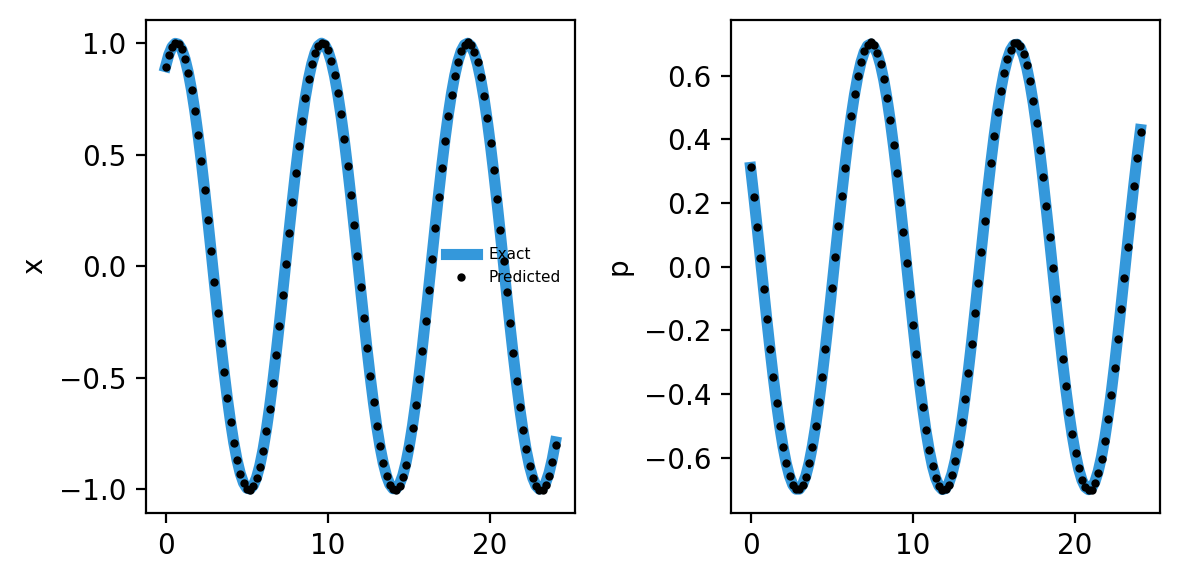

In [326]:
fig, ax = plt.subplots(1,2, figsize=(6,3), dpi = 200)
ax[0].plot(t[:sim_len], x[0,:sim_len], ls = '-', lw = 4, c = '#3498db', label = 'Exact')
ax[0].plot(t[:sim_len], predictions[:,0], ls = ' ', marker = 'o', markersize = 2, c = 'black', label = 'Predicted')
ax[1].plot(t[:sim_len], p[0,:sim_len], ls = '-', lw = 4, c = '#3498db')
ax[1].plot(t[:sim_len], predictions[:,1], ls = ' ', marker = 'o', markersize = 2, c = 'black')
ax[0].set_ylabel('x')
ax[1].set_ylabel('p')
ax[0].legend(frameon = False, fontsize = 5.5)
plt.tight_layout()
plt.show()

## Testing on unseen data

Produce new data with different phase, just run the code over and over to generate new initial conditions.

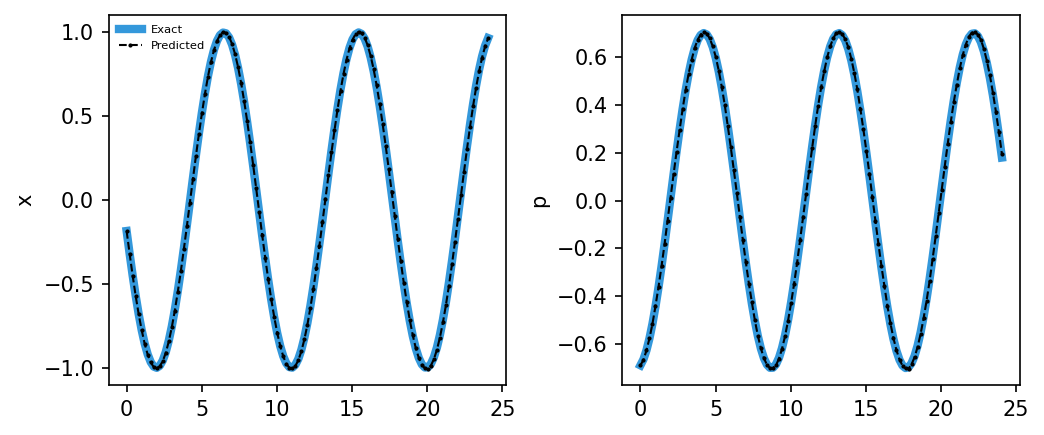

In [370]:
feat  = 2
ntraj = 1
t_len = 500
A, w, m = 1, 0.7, 1
t     = np.linspace(0, 100, t_len)
ψ     = np.random.uniform(-np.pi, np.pi, ntraj)
dat   = np.zeros((ntraj, t_len, feat))
for ψi in range(ntraj):
  dat[ψi,:,0] = A * np.cos(w * t + ψ[ψi])
  dat[ψi,:,1] = - m * w * A * np.sin(w * t + ψ[ψi])

initial_state = np.zeros((1,L-1,2))
initial_state[0,0,:] = dat[0,0,:]
num_steps     = 30
predictions   = predict_traj(model, initial_state, num_steps, device)
sim_len       = len(predictions)

fig, ax = plt.subplots(1,2, figsize=(7,3), dpi = 150)
ax[0].plot(t[:sim_len], dat[0,:sim_len,0], ls = '-', lw = 4, c = '#3498db', label = 'Exact')
ax[0].plot(t[:sim_len], predictions[:,0], ls = '--', lw = 1, marker = 'o', markersize = 1, c = 'black', label = 'Predicted')
ax[1].plot(t[:sim_len], dat[0,:sim_len,1], ls = '-', lw = 4, c = '#3498db')
ax[1].plot(t[:sim_len], predictions[:,1], ls = '--', lw = 1, marker = 'o', markersize = 1, c = 'black')
ax[0].set_ylabel('x')
ax[1].set_ylabel('p')
ax[0].legend(frameon = False, fontsize = 5.5)
plt.tight_layout()
plt.show()